Задание 1

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import re
import random
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Reshape
import numpy as np
import pandas as pd
%matplotlib inline


In [18]:
MAX_LENGTH = 10  # max length of sentences
num_samples = 15000 # Number of samples to train on.
sent_num = num_samples  # number of sentences

In [19]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?\-,&])", r" \1", s)
    s = re.sub(r"[^a-zA-ZЁёА-я.!?\-,&0-9%]+", r" ", s)
    return s


def PairCreator(path_to_corpus):
    italiantext = []
    russiantext = []
    for line in open(path_to_corpus, "r+", encoding="utf-8").readlines():
        if re.search(":it:", line) is not None:
            line = re.sub("[0-9]+:(ru|it):(.+)\\n", r"\2", line)
            russiantext.append(normalizeString(line))
        elif re.search(":ru:", line) is not None:
            line = re.sub("[0-9]+:(ru|it):(.+)\\n", r"\2", line)
            italiantext.append(normalizeString(line))
    return zip(italiantext, russiantext)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

path_to_corpus = "ML-for-compling/homeworks/HW2/grepdcorpus.txt"
ru_it = list(PairCreator(path_to_corpus))
print("Read %s sentence pairs" % len(ru_it))
input_lang = Lang("ru")
output_lang = Lang("it")
pairs = filterPairs(ru_it)
random.shuffle(pairs)
pairs = pairs[:sent_num]
print("Trimmed to %s sentence pairs" % len(pairs))
for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
print("Counted words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    x = np.array(indexes, dtype="int16")
    return np.pad(x, (0, MAX_LENGTH-len(x)), "constant")


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def onehotTensor(pairs):
    decoder_target_data = np.zeros((len(pairs), MAX_LENGTH ,output_lang.n_words), dtype="int16")
    for i, (input_text, target_text) in enumerate(pairs):
        for t, word in enumerate(target_text.split()):
            if t > 0:
                decoder_target_data[i, t - 1, output_lang.word2index[word]] = 1
    return decoder_target_data


Read 349049 sentence pairs
Trimmed to 15000 sentence pairs
Counted words:
ru 18431
it 13668


In [23]:
batch_size = 3000  # Batch size for training.
epochs = 50  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
EMBED_DIM = 256

In [24]:
# model to get decoder output data
encoder_inputs = Input(shape=(None,), dtype='int32',)
encoder_embedding = Embedding(input_dim = input_lang.n_words, output_dim = EMBED_DIM, input_length = MAX_LENGTH)(encoder_inputs)
encoder_LSTM = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,), dtype='int32',)
decoder_embedding = Embedding(input_dim = output_lang.n_words, output_dim = EMBED_DIM, input_length = MAX_LENGTH)(decoder_inputs)
decoder_LSTM = LSTM(LATENT_DIM, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

dense_layer = Dense(output_lang.n_words, activation='softmax')
outputs = (TimeDistributed(dense_layer))(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    4718336     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 256)    3499008     input_10[0][0]                   
____________________________________________________________________________________________

In [25]:
input_arrays, target_arrays = [tensorsFromPair(pair)[0] for pair in pairs], [tensorsFromPair(pair)[1] for pair in pairs]
one_hot_output = onehotTensor(pairs)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit([input_arrays, target_arrays], one_hot_output, epochs= epochs, batch_size= batch_size, validation_split=0.2)
model.save('s2s.h5')

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
12000/12000 [==============================] - 125s 10ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05
Epoch 2/50
12000/12000 [==============================] - 115s 10ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05
Epoch 3/50
12000/12000 [==============================] - 117s 10ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05
Epoch 4/50
12000/12000 [==============================] - 120s 10ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05
Epoch 5/50
12000/12000 [==============================] - 113s 9ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05
Epoch 6/50
12000/12000 [==============================] - 113s 9ms/sample - loss: 4.9069 - accuracy: 1.6667e-05 - val_loss: 4.8918 - val_accuracy: 3.3333e-05

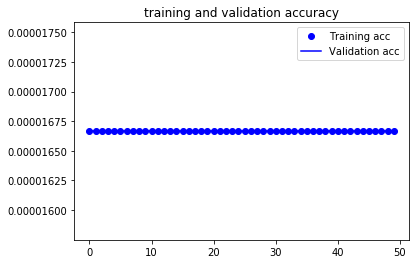

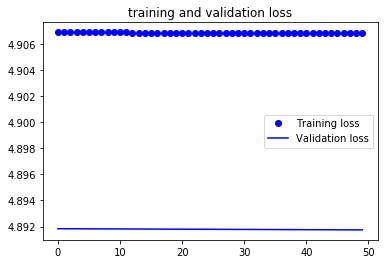

In [27]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, acc, "b", label="Validation acc")
plt.title("training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("training and validation loss")
plt.legend()

plt.show()

In [29]:
load_model('s2s.h5')
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_LSTM(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = dense_layer(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

encoder_model.summary()
decoder_model.summary()

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = input_lang.index2word
reverse_target_word_index = output_lang.index2word


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, output_lang.n_words))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_word_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'EOS' or
           len(decoded_sentence) > MAX_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, output_lang.n_words))
        target_seq[0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = input_arrays[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('>', pairs[seq_index][0])
    print('=', pairs[seq_index][1])
    print('<', decoded_sentence)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 256)         4718336   
_________________________________________________________________
unified_lstm_8 (UnifiedLSTM) [(None, 256), (None, 256) 525312    
Total params: 5,243,648
Trainable params: 5,243,648
Non-trainable params: 0
_________________________________________________________________
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None)]       0                                            
_________________________________________________________________